# Dataset
*Sparkify* is a *music streaming service*. Just like other famous streaming services (e.g. Spotify), users can choose free tier subscription with ads or paid tier without ads. They are free to upgrade, downgrade, or cancel their subscription plan.

# Task
The tasks consist of a binary classification problem where in this case the objective is to identify clients more likely to churn. If we can identify which users are at-risk to churn, then the business can take action and potentially make them stay.

# Evaluation metrics
- Because of the high imbalanced class ratio in the data, accuracy is inappropriate as evaluation metric.

- The main reason is that the overwhelming number of examples from the majority class will overwhelm the number of examples in the minority class, meaning that even unskillful models can achieve accuracy scores of 90 percent, or 99 percent, depending on how severe the class imbalance happens to be.

- Since our goal is to predict the users more likely to churn (postive class), **F1-score** of positive class has been considerend as main reference to select the best model for the current problem. At the same time also AUC-PR turned out to be good indicator to evaluate the performances of the models. 

# Import libraries

In [ ]:
# Import libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import avg, col, concat, desc, lit, min, max, split, udf, countDistinct, sum, count
from pyspark.sql.types import IntegerType, DoubleType
from pyspark.sql import Window

from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression,GBTClassifier,LinearSVC, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

import seaborn as sns

# Create spark session

In [ ]:
# for cluster mode
"""
from pyspark.sql import SparkSession

spark = SparkSession.\
        builder.\
        appName("sparkify").\
        master("spark://spark-master:7077").\
        config("spark.executor.memory", "5120m").\
        getOrCreate()
"""

In [ ]:
# for local mode
spark = SparkSession.builder.getOrCreate()

In [ ]:
file_json = 'mini_sparkify_event_data.json'

# Load data

In [ ]:
# Read json data
df = spark.read.json(file_json)
df.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

In [ ]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [ ]:
# Total number of patterns
print('Total activity records: ',df.count())

Total activity records:  286500


In [ ]:
# Get auth summary
df.groupby('auth').agg(countDistinct('userId')).show()

+----------+-------------+
|      auth|count(userId)|
+----------+-------------+
|Logged Out|            1|
| Cancelled|           52|
|     Guest|            1|
| Logged In|          225|
+----------+-------------+



## Churn Definition
In this study, we define churn as a user who cancelled the subscription and left Sparkify. When users submits cancellation, the record will have auth == 'Cancelled' and page == 'Cancellation Confirmation' . The cancellation is effective immediately.

# Data preprocessing
The first step of our analysis consists of preprocessing the input data: 
- As showed above, there are users whose *auth* field is set to Logged out or Guest. They are not useful for our purposes so we can get rid of them.
- Now, we can map our target label as follows: Logged in --> 0, Cancelled --> 1
- Convert time stamp format to date time format
- Map the gender as follows: Male --> 0, Female --> 1

In [ ]:
def clean_data(df_input):
    # Filter out status Guest and Logged Out to exclude guests
    df_clean = df.filter( (col('auth') == 'Logged In' ) | (col('auth') == 'Cancelled') )

    # fucntion for mapping Churn: {not_churn=0, churn=1}
    map_labels = udf(lambda auth: 1 if auth == 'Cancelled' else 0, IntegerType())
    df_clean = df_clean.withColumn('cancel', map_labels('auth'))

    # convert ts in date format
    df_clean = df_clean.withColumn("date", F.to_date(F.from_unixtime(col('ts')/lit(1000))))

    # Convert gender to 1/0. 1 = female
    female = udf(lambda x: 1 if x == 'F' else 0, IntegerType())
    df_clean = df_clean.withColumn('female', female('gender'))

    return df_clean

In [ ]:
df_clean = clean_data(df)
# Check for nulls
print("Number of nulls in userId:", df_clean.filter(df_clean.userId == '').count())
print("Number of nulls in sessionId:", df_clean.filter(df_clean.sessionId == '').count())

Number of nulls in userId: 0
Number of nulls in sessionId: 0


In [ ]:
df_clean.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------+----------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|cancel|      date|female|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+------+----------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|     0|2018-10-01|     0|
|Five Iron Frenzy|Logged In|    Mica

# Exploratory Data Analysis (EDA)
## User Activities

In [ ]:
# All user activity types
pages = df_clean.groupby('page','method').count().sort('method')
pages.show()

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|               About|   GET|   495|
|             Upgrade|   GET|   499|
|            Settings|   GET|  1514|
|               Error|   GET|   252|
|                Help|   GET|  1454|
|Cancellation Conf...|   GET|    52|
|                Home|   GET| 10082|
|           Downgrade|   GET|  2055|
|         Roll Advert|   GET|  3933|
|          Add Friend|   PUT|  4277|
|              Logout|   PUT|  3226|
|      Submit Upgrade|   PUT|   159|
|       Save Settings|   PUT|   310|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|         Thumbs Down|   PUT|  2546|
|            NextSong|   PUT|228108|
|    Submit Downgrade|   PUT|    63|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



## Proactive users
In addition to playing songs, users can also rate the songs, change settings and add friends. Are users with more interactions on Sparkify more sticky to the platform? Will users leave because they got too many songs they don’t like in their feed?

We can consider as *proactive users* the ones who perform a *PUT* operations. As shown in the plot below, the most common activities (after reproducing a song) is *Thumbs Up*

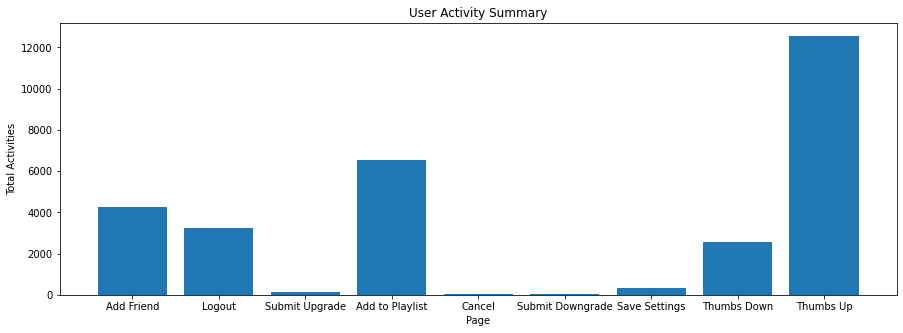

In [ ]:
# Use'PUT' to get user proactive activities
pages_df = pages.toPandas()
pages_df_plt = pages_df.loc[(pages_df['method'] == 'PUT') & (pages_df['page'] != 'NextSong')]

activity = pages_df_plt['page']
count = pages_df_plt['count']
plt.figure(figsize=(15,5))
plt.bar(activity, count)
plt.ylabel('Total Activities')
plt.xlabel('Page')
plt.title('User Activity Summary')

plt.show()

## Example of user downgrade
- Downgrade happens right after user submit downgrade

In [ ]:
# Example of user downgrade
# Downgrade happens right after user submit downgrade
df_clean.filter(col('userId') == '131').groupby(['level','sessionId','page']\
                                         ).agg(min(col('date')).alias('date'),\
                                              sum(col('length')).alias('length')).sort(col('date').desc()).show(30)


+-----+---------+----------------+----------+------------------+
|level|sessionId|            page|      date|            length|
+-----+---------+----------------+----------+------------------+
| free|     2281|            Home|2018-11-30|              null|
| free|     2155|       Thumbs Up|2018-11-25|              null|
| free|     2155| Add to Playlist|2018-11-25|              null|
| free|     2155|        NextSong|2018-11-25|11182.815799999997|
| free|     2155|     Thumbs Down|2018-11-25|              null|
| free|     2155|     Roll Advert|2018-11-25|              null|
| free|     2155|            Home|2018-11-25|              null|
| free|     2155|           About|2018-11-25|              null|
| free|     2155|          Logout|2018-11-25|              null|
| free|     2155|      Add Friend|2018-11-25|              null|
| free|     2094|        NextSong|2018-11-21|         563.35582|
| free|     2094|            Home|2018-11-21|              null|
| free|     2041|     Rol

## User most common locations

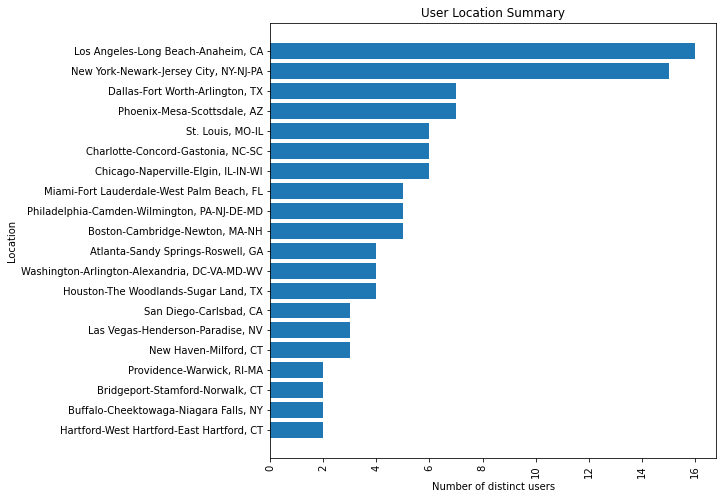

In [ ]:
# Get user location
df_loc = df_clean.groupby('location').agg(countDistinct('userId')).toPandas()
df_loc = df_loc.sort_values('count(userId)').iloc[-20:,:]

plt.figure(figsize=(8,8))
plt.barh(df_loc['location'], df_loc['count(userId)'])
plt.ylabel('Location')
plt.xlabel('Number of distinct users')
plt.title('User Location Summary')
plt.xticks(rotation='vertical')

plt.show()

## Gender distribution between regular and churn users

In [ ]:
churn_gender_df = df_clean.groupby(['cancel', 'gender']).agg(countDistinct('userId')).toPandas()
churn_gender_df

,cancel,gender,count(userId)
0,1,F,20
1,0,M,121
2,1,M,32
3,0,F,104


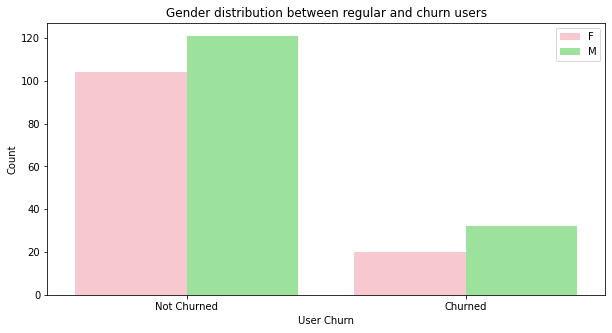

In [ ]:
# Plotting a bar plot to show gender distribution between regular and churn users
fig, ax = plt.subplots(figsize=(10, 5))
plt.title('Gender distribution between regular and churn users')
ax = sns.barplot(x = 'cancel', y = 'count(userId)', data = churn_gender_df, hue = "gender", palette = ["pink", "lightgreen"])

ax.set(xticklabels=['Not Churned', 'Churned'])

ax.set_ylabel('Count')
ax.set_xlabel('User Churn')
ax.legend()

## Paid/Free customers

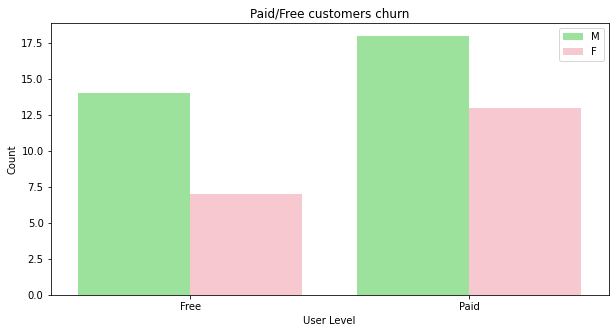

In [ ]:
# Plotting a bar plot to show differense between Paid/Free customers churn per gender
fig, ax = plt.subplots(figsize=(10, 5))

df_level_pd = df_clean.filter('page == "Cancellation Confirmation"').groupby(['level', 'gender']).count().toPandas()
plt.title('Paid/Free customers churn')
sns.barplot(data = df_level_pd, x = 'level', y = 'count',  hue = 'gender', palette = ["lightgreen", "pink"])

ax.set(xticklabels=['Free', 'Paid'])

ax.set_ylabel('Count')
ax.set_xlabel('User Level')
ax.legend()

## Activity Dates
The date range in the dataset is *2018-09-30* to *2018-12-02*. We can see paid tier and free tier has similar numbers of user sessions and distinct user at the beginning, then both metrics increased over time for the paid tier as the metrics decreased for free users.


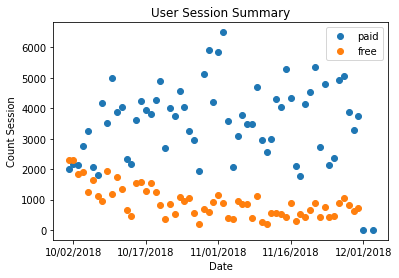

In [ ]:
# Get user activity summary over time
time = df_clean.select(['date','sessionId','userId','level','song']\
                      ).groupby(['date','level']).agg(F.count(col('sessionId')), F.countDistinct(col('userId')),\
                                                      F.count(col('song')))

# Export to pandas for visualization
df_time = time.toPandas()
df_time.head()

# Count session over time
date = df_time['date']
count = df_time['count(sessionId)']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

# beautifying the labels
plt.plot_date(df_time['date'][df_time.level == "paid"], df_time['count(sessionId)'][df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], df_time['count(sessionId)'][df_time.level == "free"], label = 'free')
plt.legend()
plt.ylabel('Count Session')
plt.xlabel('Date')
plt.title('User Session Summary')
plt.show()

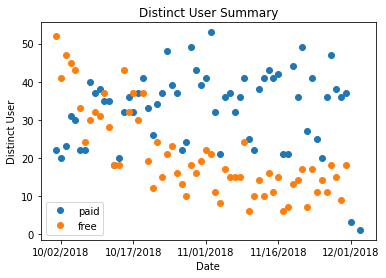

In [ ]:
# Count user over time
date = df_time['date']
count = df_time['count(userId)']

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%m/%d/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))

plt.plot_date(df_time['date'][df_time.level == "paid"], count[df_time.level == "paid"], label = 'paid')
plt.plot_date(df_time['date'][df_time.level == "free"], count[df_time.level == "free"], label = 'free')
plt.ylabel('Distinct User')
plt.xlabel('Date')
plt.title('Distinct User Summary')
plt.legend()
plt.show()

# User churn since registration
How long will a user stay on Sparkify before they churn? From the histogram of user age at the time of churn, we can see most churns happens within 100 days after registration.


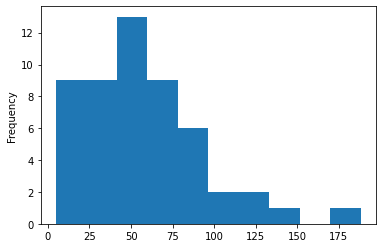

In [ ]:
# User registration date
df_cancel = df_clean.withColumn('date_created', F.to_date(F.from_unixtime(col('registration')/lit(1000))))
# Get user age at the activity date
df_cancel = df_cancel.withColumn('user_age',F.datediff(col('date'),col('date_created')))
#User cancel by age
df_cancel = df_cancel.filter(col('cancel') == 1).select(['date','user_age','level']).toPandas()

df_cancel['user_age'].plot(kind='hist')

# Features engineering
Based on the analysis carried out still now thanks to EDA, we are ready to extract the features that actually will allow us to understand clients more prone to churn.

In this regards, I decided to define the following 11 features:
- `gender`: male or female
- `days_registered`: number of days the user is registered
- `paid_user`: free account or premium account
- `downgraded`: has the user ever downgraded from premium to free?
- `artists`: average number of artits listened per session by the user
- `songs`: average number of songs listened per session by the user 
- `length`: average second listened of songs per session by the user
- `interactions`: average proactive operations performed by the user per session 
- `thumbs_down`: average thumbs down released by the user per session
- `total_session`: total number of session 
- `session_gap`: average time between each session and the pevious one

The operations aimed at their extrapolation have been defined inside the function `exctract_features()` below.


In [ ]:
def extract_features(df_input):

    # User registration date
    df_feat = df_input.withColumn('date_created', F.to_date(F.from_unixtime(col('registration')/lit(1000))))
    # Get user age at the activity date
    df_feat = df_feat.withColumn('days_registered',F.datediff(col('date'),col('date_created')))

    # Get user interactions except for playing songs
    inter = ['Thumbs Up', 'Add to Playlist', 'Add Friend', 'Thumns Down']
    get_interactions = udf(lambda x: 1 if x in inter else 0, IntegerType())

    # Get negative feedback from user
    thumbs_up = udf(lambda x: 1 if x == 'Thumbs Up' else 0, IntegerType())
    
    df_feat = df_feat.withColumn('interactions', get_interactions('page'))
    df_feat = df_feat.withColumn('thumbs_up', thumbs_up('page'))

    # Get number of songs played
    songs = udf(lambda x: 1 if x == 'NextSong' else 0, IntegerType())
    df_feat = df_feat.withColumn('songs', songs('page'))

    # Has the user ever used paied service
    paid_hist = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
    df_feat = df_feat.withColumn('paid_hist', paid_hist('level'))

    # Has the user ever downgraded
    downgrade = udf(lambda x: 1 if x == 'Submit Downgrade' else 0, IntegerType())
    df_feat = df_feat.withColumn('downgraded', downgrade('page'))

    # Get user level dimensions
    dims = df_feat.groupby('userId','female','date_created').agg(\
                                                          max('days_registered').alias('days_registered'),\
                                                          max('paid_hist').alias('paid_user'),\
                                                          max('downgraded').alias('downgraded'),\
                                                          max('cancel').alias('canceled'))

    # Get measures based on usersessions and interactions
    measures = df_feat.groupby('userId','sessionId').agg(\
                                                          min('date').alias('start_date'),\
                                                          max('date').alias('end_date'),\
                                                          sum('interactions').alias('interactions'),\
                                                          sum('thumbs_up').alias('thumbs_up'),\
                                                          sum('songs').alias('songs'),\
                                                          sum('length').alias('length'),\
                                                          countDistinct('artist').alias('c_artist'))
    
    # Get the date gap between sessions

    #get the previous end date
    measures_lag = measures.withColumn('prev_end_date',
                            F.lag(col('end_date')).over(Window.partitionBy('userID').orderBy('start_date')))

    measures_lag = measures_lag.withColumn('session_gap', F.datediff(col('start_date'),col('prev_end_date')))

    measures_agg = measures_lag.groupby('userId').agg(\
                                                    F.count('sessionId').alias('total_session'),\
                                                    avg('interactions').alias('interactions'),\
                                                    avg('thumbs_up').alias('thumbs_up'),\
                                                    avg('songs').alias('songs'),\
                                                    avg('length').alias('length'),\
                                                    avg('c_artist').alias('artists'),\
                                                    avg('session_gap').alias('session_gap'))
    
    # Join dims and measures
    output = dims.join(measures_agg, on = 'userId')

    return output

In [ ]:
output = extract_features(df_clean)
output.show(5)

+------+------+------------+---------------+---------+----------+--------+-------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|userId|female|date_created|days_registered|paid_user|downgraded|canceled|total_session|     interactions|        thumbs_up|             songs|            length|           artists|       session_gap|
+------+------+------------+---------------+---------+----------+--------+-------------+-----------------+-----------------+------------------+------------------+------------------+------------------+
|    10|     0|  2018-09-28|             52|        1|         0|       0|            6|9.666666666666666|6.166666666666667|112.16666666666667|      27811.062085|104.66666666666667|               8.0|
|   100|     0|  2018-09-26|             65|        1|         1|       0|           35|7.371428571428571|4.228571428571429| 76.62857142857143|19790.525193823534| 72.45714285714286|1.5294117647058

# Features distribution

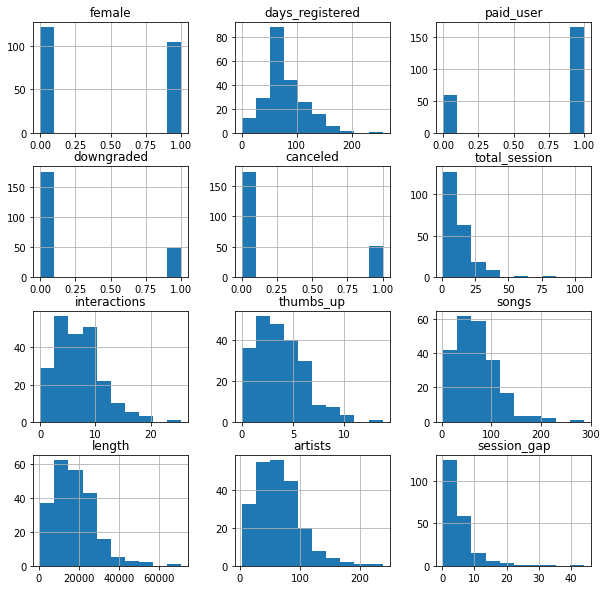

In [ ]:
# Inspect aggregated data
model_df = output.toPandas()
hist = model_df.hist(figsize = (10,10))

# Target class distribution
Just have a look more in detail to our target variable canceled.

In [ ]:
def get_class_distribution(df_input, col):
    """
    Function to plot class distribution
    """
    label_count = df_input[col].value_counts() 

    # bar plot
    plot = sns.barplot(list(label_count.index), list(label_count.values)) 
    plt.title('Class Distribution')
    plt.xlabel('Class Label')
    plt.ylabel('Count')

    # adding class count to the barplot
    for patch in plot.patches:
        # formatting and positioning the count values
        plot.annotate('{:n}'.format(patch.get_height()), 
                      (patch.get_x()+0.35, patch.get_height()+1)) 
    plt.show()

In [ ]:
def percentage_cls_distrib(df_input):
    """
    function to get % class distribution among train and test data
    """
    total = len(df_input)
    class_0 = round(df_input.value_counts()[0] *100 / total, 2)
    class_1 = round(df_input.value_counts()[1] *100 / total, 2)
    print(f"% Negative class data points = {class_0}")
    print(f"% Positive class data points= {class_1}")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


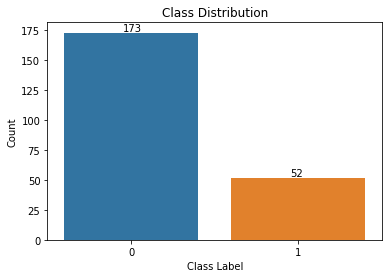


% Negative class data points = 76.89
% Positive class data points= 23.11


In [ ]:
get_class_distribution(model_df, "canceled")
print()
percentage_cls_distrib(model_df["canceled"])

As shown by the plot, there is an *high imbalanced class ratio*. Positive class is only about 23% of the total distribution.

# Correlation among features 


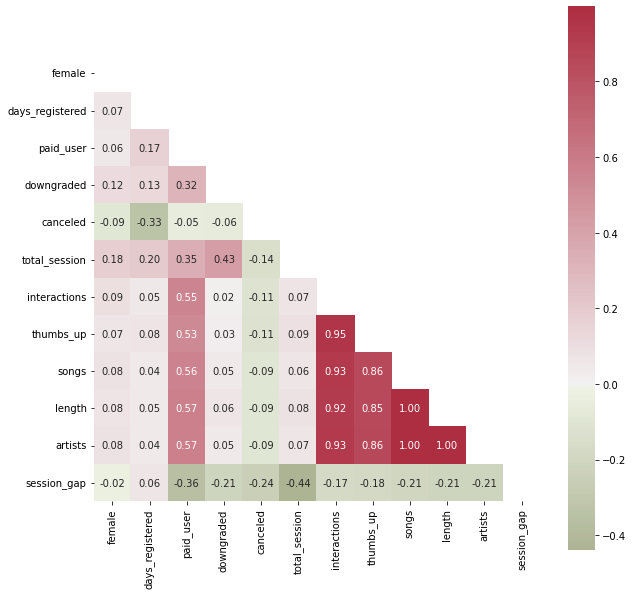

In [ ]:
# Get correlations

# Calculate pairwise-correlation
matrix = model_df.corr()

# Create a mask
mask = np.triu(np.ones_like(matrix, dtype=bool))

# Create a custom divergin palette
cmap = sns.diverging_palette(100, 7, s=75, l=40,
                            n=5, center="light", as_cmap=True)

plt.figure(figsize=(10, 10))
sns.heatmap(matrix, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap=cmap)

plt.show();

# Features selection
There is no obvious strong predictor for `cancelled` except for `user_age`

`songs`, `interactions`, `thumbs_up`, `length`, `artists` are very similar according to the histograms. Although they all show high correlation with each other, this is possibly caused by the small dataset (225 users). If we have more data, we might see more variance in user behaviors. Therefore, we will **only exclude songs and artists** as they will always be similar to length .

# Example of distribution between correlated features 
To give a further proof of the linear dependence among `length`, `artist` and `songs`, their interactions plots are shown:

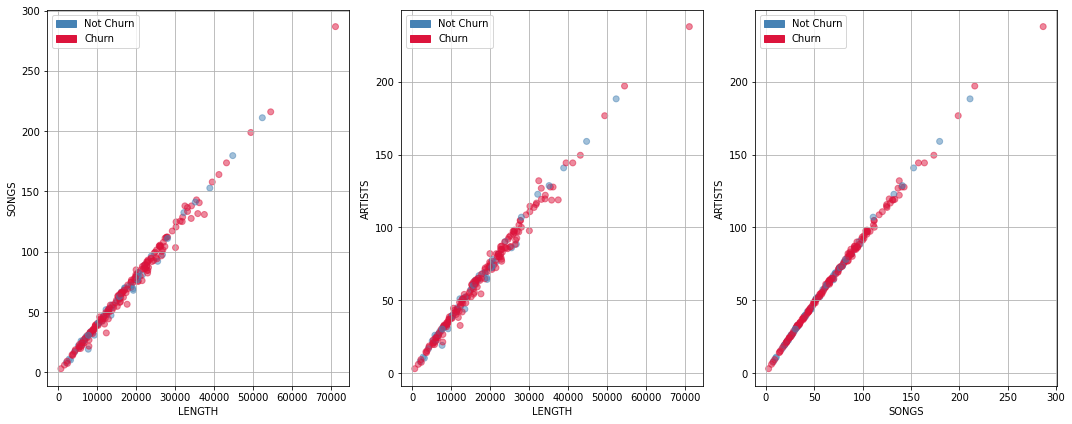

In [ ]:
import matplotlib.patches as mpatches
import matplotlib

data_np=output.toPandas()
target=data_np.canceled

# variables to 
LENGTH = data_np['length'].to_numpy()
SONGS = data_np['songs'].to_numpy()
ARTISTS = data_np['artists'].to_numpy()

fig, ax = plt.subplots(1,3, figsize= (15,6))

labels=["Not Churn","Churn"]
pop_a = mpatches.Patch(color='steelblue', label='Not Churn')
pop_b = mpatches.Patch(color='crimson', label='Churn')
colors=['crimson', 'steelblue']

ax[0].scatter(LENGTH, SONGS, c=target, cmap=matplotlib.colors.ListedColormap(colors), label=labels, alpha=0.5)
ax[0].grid()
ax[0].set_xlabel('LENGTH')
ax[0].set_ylabel('SONGS')
ax[0].legend(handles= [pop_a,pop_b])

ax[1].scatter(LENGTH, ARTISTS, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[1].grid()
ax[1].set_xlabel('LENGTH')
ax[1].set_ylabel('ARTISTS')
ax[1].legend(handles= [pop_a,pop_b])

ax[2].scatter(SONGS, ARTISTS, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[2].grid()
ax[2].set_xlabel('SONGS')
ax[2].set_ylabel('ARTISTS')
ax[2].legend(handles= [pop_a,pop_b])

plt.tight_layout()# let's make good plots
plt.show()

The charts confirm what expected, the features in the same graph shows a linear trend as the Pearson coefficient suggested, indicating they encode pretty similar information.

# Example of distribution between un-correlated features 
For completness, also charts of non-strongly correlated features are reported. In particular:
- ***interactions*** and ***total_session*** $p$ = 0.07
- ***interactions*** and ***session_gap*** $p$ = -0.17
- ***days_registered*** and ***total_session*** $p$ = 0.20

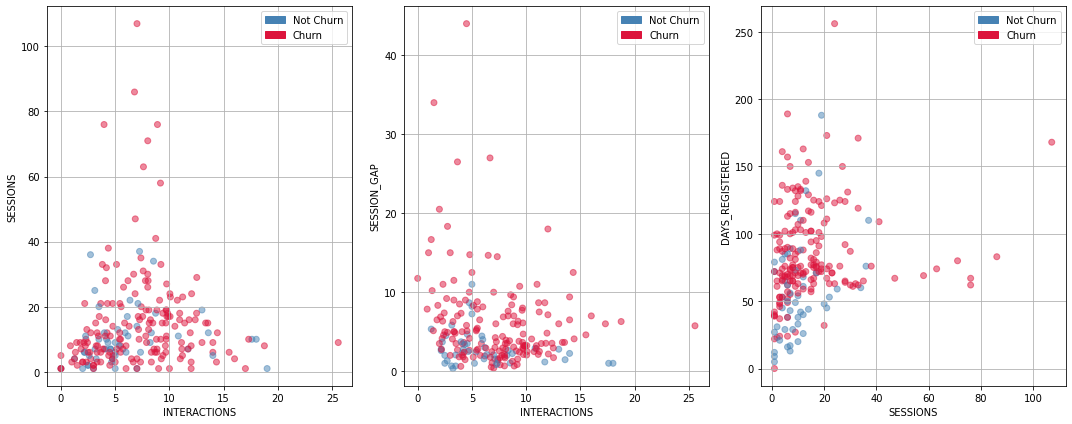

In [ ]:
import matplotlib.patches as mpatches
import matplotlib

data_np=output.toPandas()
target=data_np.canceled

# variables to 
INTERACTIONS = data_np['interactions'].to_numpy()
SESSIONS = data_np['total_session'].to_numpy()
SESSION_GAP = data_np['session_gap'].to_numpy()
DAYS_REGISTERED = data_np['days_registered'].to_numpy()

fig, ax = plt.subplots(1,3, figsize= (15,6))

labels=["Not Churn","Churn"]
pop_a = mpatches.Patch(color='steelblue', label='Not Churn')
pop_b = mpatches.Patch(color='crimson', label='Churn')
colors=['crimson', 'steelblue']

ax[0].scatter(INTERACTIONS, SESSIONS, c=target, cmap=matplotlib.colors.ListedColormap(colors), label=labels, alpha=0.5)
ax[0].grid()
ax[0].set_xlabel('INTERACTIONS')
ax[0].set_ylabel('SESSIONS')
ax[0].legend(handles= [pop_a,pop_b])

ax[1].scatter(INTERACTIONS, SESSION_GAP, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[1].grid()
ax[1].set_xlabel('INTERACTIONS')
ax[1].set_ylabel('SESSION_GAP')
ax[1].legend(handles= [pop_a,pop_b])

ax[2].scatter(SESSIONS, DAYS_REGISTERED, c=target, cmap=matplotlib.colors.ListedColormap(colors), alpha=0.5)
ax[2].grid()
ax[2].set_xlabel('SESSIONS')
ax[2].set_ylabel('DAYS_REGISTERED')
ax[2].legend(handles= [pop_a,pop_b])

plt.tight_layout()# let's make good plots
plt.show()

# Outliers removal
There is a particular category of users to consider before making inference: the users whose total session is equal to 1. They are probably new users just entered in the application and their session_gap is indeed equal to NaN.  However, here we are trying to predict people who used to be an active user but decides to leave. For this reason, they are out of the scope of our analysis and we will exclude them from the prediction.

In [ ]:
# Inspect aggregated data
model_df.loc[model_df.isnull().sum(axis = 1) > 0]

,userId,female,date_created,days_registered,paid_user,downgraded,canceled,total_session,interactions,thumbs_up,songs,length,artists,session_gap
7,100006,1,2018-09-26,9,0,0,1,1,7.0,2.0,26.0,5854.89105,26.0,NaN
12,100011,0,2018-09-26,5,0,0,1,1,2.0,0.0,11.0,2841.69950,11.0,NaN
18,100017,0,2018-08-02,79,0,0,1,1,3.0,2.0,52.0,12261.72340,51.0,NaN
24,100024,0,2018-09-07,27,0,0,1,1,5.0,5.0,22.0,5160.53207,22.0,NaN
52,125,0,2018-08-01,72,0,0,1,1,0.0,0.0,8.0,2089.11310,8.0,NaN
60,133,0,2018-09-05,40,0,0,0,1,6.0,2.0,32.0,8029.16428,32.0,NaN
62,135,1,2018-07-24,72,0,0,0,1,0.0,0.0,6.0,1596.44461,6.0,NaN
80,151,0,2018-09-25,42,1,0,0,1,9.0,4.0,138.0,32481.13906,132.0,NaN
85,156,0,2018-11-26,0,0,0,0,1,0.0,0.0,3.0,691.66884,3.0,NaN
89,19,1,2018-09-18,22,1,0,0,1,17.0,5.0,216.0,54480.93387,197.0,NaN


# Modeling
Features must be prepared in the right way in order to be fed to the model.  In this regards, a couple of futher steps are needed:
- **Assembling**:  for each reacord, its features must be assembled in a unique array. Pyspark provides the function *VectorAssembler()* which takes as input the features selected and the name of the column which will contain their assembling. Indeed, the function creates an array which aggregates all the features toghether.

- **Scaling**: After being assembled, the features must be scaled by exploiting the function StandardScaler()

In [ ]:
# Assemble num features
assembler = VectorAssembler(inputCols=['female','days_registered','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_up','length','session_gap'],\
                            outputCol='NumFeatures')

# Standard Scaler
standardscaler = StandardScaler(inputCol="NumFeatures", outputCol="features", withMean=True, withStd=True)

# Split train and test set 
The split has been randomly generated but kept the same for all the tested approaches, in order to make evaluations statistically meaningful and provide consistent results among the different classifiers. This has been obtained by setting the random seed = 42. This specific seed allowed also to maintain the proportion of churn/non-churn clients in each of the final sets approximately the same as in the initial data. This approach is desirable every time we have a highly unbalanced dataset as in our case.

In [ ]:
data = output.dropna()
data = assembler.transform(data)
# Use 'canceled' as model prediction label
data = data.withColumnRenamed('canceled','label')

In [ ]:
# Split train/test data and set seed for reproducibility
train, test = data.randomSplit([0.75, 0.25], seed=42)

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


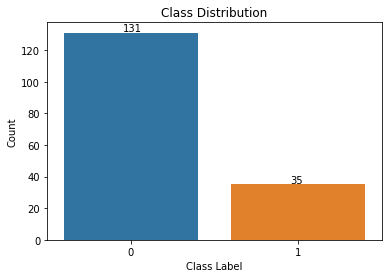

In [ ]:
# class distribution in train set 
get_class_distribution(train.toPandas(), "label")

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


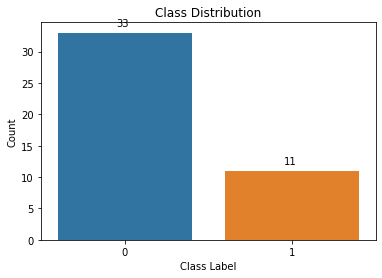

In [ ]:
# class distribution in test set 
get_class_distribution(test.toPandas(), "label")

In [ ]:
train.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   35|
|    0|  131|
+-----+-----+



In [ ]:
test.groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    1|   11|
|    0|   33|
+-----+-----+



# Custom evaluator for cross validation
Since our objective is to maximize the ability of the model to predict users more likely to churn, I decided to define a custom evaluator which consider as reference metric only the F1 score of the positive class 1(churn). 
To do so, it is necessary to extend the MulticlassClassificationEvaluator class and override the *evaluate* method.

In [ ]:
class F1PositiveEvaluator(MulticlassClassificationEvaluator):

    def __init__(self, predictionCol="prediction", labelCol="label"):
        super(F1PositiveEvaluator, self).__init__(predictionCol=predictionCol, labelCol=labelCol)

    def evaluate(self, dataset):
        predictionAndLabels = dataset.select(self.getPredictionCol(), self.getLabelCol()).rdd.map(lambda lp: (float(lp[0]), float(lp[1])))
        metrics = MulticlassMetrics(predictionAndLabels)
        return metrics.fMeasure(1.0)

In [ ]:
# the same as above but by extending BinaryClassificationEvaluator class
"""
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col

class F1ScoreEvaluator(BinaryClassificationEvaluator):

    def __init__(self, rawPredictionCol="prediction", labelCol="label"):
        super(F1ScoreEvaluator, self).__init__(rawPredictionCol=rawPredictionCol, labelCol=labelCol)

    def evaluate(self, dataset):
        predictionAndLabels = dataset.select(self.getRawPredictionCol(), self.getLabelCol()).rdd.map(lambda lp: (float(lp[0]), float(lp[1])))
        metrics = MulticlassMetrics(predictionAndLabels)
        return metrics.fMeasure(1.0)
"""

In [ ]:
# Create an instance of F1PositiveEvaluator
F1_pos_evaluator = F1PositiveEvaluator()
#F1_pos_evaluator = F1ScoreEvaluator()

# Model fine-tuning
To find the best model and parameters, we use CrossValidator to evaluate the model performance and validate the robustness of the models. With numFolds = 3 , the CrossValidator generates 3 sets of training/testing pairs, each of which uses 2/3 of the data for training and 1/3 for testing. To evaluate a particular model/param selection, CrossValidator computes the average evaluation metrics for the 3 models fitted on the 3 train/test pairs.

In [ ]:
def fit_model(model, train_input, test_input, paramGrid = None, train_score = False):
    # Input: model, train set, test set, paramgrid (optional) and train_score (optional)
    # Output: fitted model, prediction on test set, prediction on train set (optional)
    pipeline = Pipeline(stages=[standardscaler, model])
    
    if paramGrid != None:
        crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=F1_pos_evaluator,
                          numFolds=3)
        fitmodel = crossval.fit(train_input)
    else:
        fitmodel = pipeline.fit(train_input)
    
    results = fitmodel.transform(test_input)

    if train_score:
        results_train = fitmodel.transform(train_input)
        return fitmodel, results, results_train
    else:
        return fitmodel, results
    

# Evaluation function
The function evaluates the model according to:
- F1 score (positive class)
- Precision (positive class)
- Recall (positive class)
- F1 avg macro
- AUC-PR

In [ ]:
# Evaluate the model on validation set
def val_evaluation(results):
    # Input: prediction results
    # Output: f1, precision and recall score of postive class + AUC-PR
    predictionAndLabels = results.select(['prediction', 'label']).withColumn('label',col('label').cast(DoubleType())).rdd

    metrics = MulticlassMetrics(predictionAndLabels)
    print("Precision:", metrics.precision(1))
    print("Recall:", metrics.recall(1))
    print("F1 positive class:", metrics.fMeasure(1.0))
    f1_macro = (2*(metrics.recall(1) * metrics.precision(1)) / (metrics.recall(1) + metrics.precision(1)) + 2*(metrics.recall(0) * metrics.precision(0)) / (metrics.recall(0) + metrics.precision(0)))/2
    print("F1 macro:", f1_macro)
   
    #AUC
    predictionAndLabels = results.select(['prediction', 'label'])
    auc_evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction', labelCol='label')
    pr = auc_evaluator.evaluate(predictionAndLabels, {auc_evaluator.metricName: "areaUnderPR"})
    print("AUC-PR:", pr, "\n")

    #return(round(f1_positive_label,2), round(precision,2),round(recall,2), round(pr,2))

# Models selection
I decided to compare the performances of 4 different models: 
- Logistic Regression
- Random Forest Classifier
- SVM (linear kernel)
- GBT Classifier

# Logistic regression

In [ ]:
lr = LogisticRegression()

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.0, 0.0001, 0.1])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [5, 10, 20])
             .build())

In [ ]:
lrmodel, lrresults = fit_model(lr, train, test, paramGrid=paramGrid )
val_evaluation(lrresults)

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 1.0
Recall: 0.5454545454545454
F1 positive class: 0.7058823529411764
F1 macro: 0.8177299088649543
AUC-PR: 0.8295454545454546 



In [ ]:
best_param = list(lrmodel.getEstimatorParamMaps()[np.argmax(lrmodel.avgMetrics)].values())
print('Best LR parameters are:', best_param[0], best_param[1], best_param[2])

Best LR parameters are: 0.0001 1.0 10


In [ ]:
lr = LogisticRegression(elasticNetParam=1.0, regParam = 0.0001, maxIter=10)
lrmodel, lrresults, train_res = fit_model(lr, train, test, train_score = True)
print("TRAIN results:")
val_evaluation(train_res)
print("TEST results:")
val_evaluation(lrresults)

TRAIN results:


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.8518518518518519
Recall: 0.6571428571428571
F1 positive class: 0.7419354838709677
F1 macro: 0.8413381123058542
AUC-PR: 0.7419646841333589 

TEST results:
Precision: 1.0
Recall: 0.5454545454545454
F1 positive class: 0.7058823529411764
F1 macro: 0.8177299088649543
AUC-PR: 0.8295454545454546 



## PR Curve
The Precision-Recall curve plots the precision (the number of true positive predictions divided by the sum of true positive and false positive predictions) against the recall (the number of true positive predictions divided by the sum of true positive and false negative predictions) for different threshold values of the classifier's predicted probabilities. The AUC-PR measures the area under this curve, and a higher AUC-PR value indicates a better balance between precision and recall for the minority class.

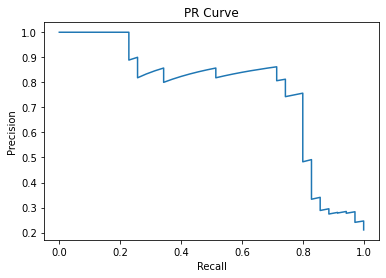

In [ ]:
# lr model PR curve
trainingSummary = lrmodel.stages[-1].summary
#Returns the precision-recall curve, which is an Dataframe containing two fields reca
pr = trainingSummary.pr.toPandas()

plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('PR Curve')
plt.show()

## Coefficients
In logistic regression for binary classification, the coefficients represent the change in the log odds of the dependent variable (the binary outcome) for a one unit change in the independent variable, while holding all other variables constant.

- session_gap, total_sessiom and interactions are inversely correlated with the probability of churn, so the higher their value, the less the probability of the client to churn 
- On the other hand, the length and the typology of the user turned out to be features directly correlated with the probability of being a churn.

Text(0, 0.5, 'Coefficient')

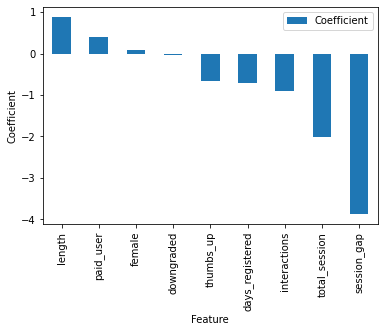

In [ ]:
exp_features = ['female','days_registered','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_up','length','session_gap']
FI = lrmodel.stages[-1].coefficients
model_FI = pd.DataFrame(list(zip(exp_features, FI)),  columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
        
model_FI.plot.bar(x='Feature', y='Coefficient')
plt.ylabel('Coefficient')

# Random Forest


In [ ]:
rf = RandomForestClassifier(maxDepth = 5, numTrees = 10)

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [2, 3, 5])
             .addGrid(rf.numTrees, [2, 5, 10])
             .build())

In [ ]:
rfmodel, rfresults, train_res = fit_model(rf, train, test, paramGrid = paramGrid, train_score = True)
print("TRAIN results:")
val_evaluation(train_res)
print("TEST results:")
val_evaluation(rfresults)

TRAIN results:
Precision: 1.0
Recall: 0.6857142857142857
F1 positive class: 0.8135593220338984
F1 macro: 0.8866331408704291
AUC-PR: 0.8759896729776248 

TEST results:
Precision: 0.8
Recall: 0.36363636363636365
F1 positive class: 0.5000000000000001
F1 macro: 0.6944444444444444
AUC-PR: 0.625 



In [ ]:
best_param = list(rfmodel.getEstimatorParamMaps()[np.argmax(rfmodel.avgMetrics)].values())
print('Best RF parameters are:', best_param[0], best_param[1])

Best RF parameters are: 5 10


## Features importances
In a Random Forest Classifier, feature importance is a measure of the contribution of each feature to the prediction accuracy of the model.
From the plot we can see as paid_user and downgraded are the feature with the least impact on churn prediction, while days_registered and session_gap turned out to be the most important.

Text(0, 0.5, 'FeatureImportances')

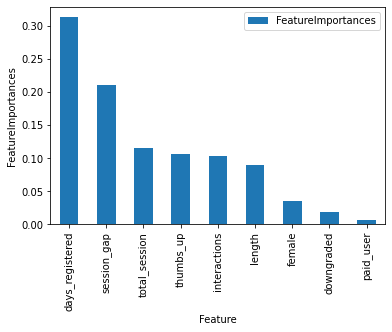

In [ ]:
FI = rfmodel.stages[-1].featureImportances
model_FI = pd.DataFrame(list(zip(exp_features, FI)), columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)
model_FI.plot.bar(x='Feature', y='FeatureImportances')
plt.ylabel('FeatureImportances')

# SVM

In [ ]:
lsvc = LinearSVC()
lsvc.setThreshold(0.5)

In [ ]:
# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lsvc.regParam, [0.0, 0.001, 0.01])
             .addGrid(lsvc.maxIter, [5, 10, 20])
             .build())

In [ ]:
lsvcmodel, lsvcresults, train_res = fit_model(lsvc, train, test, paramGrid = paramGrid, train_score = True)
print("TRAIN results:")
val_evaluation(train_res)
print("TEST results:")
val_evaluation(lsvcresults)

TRAIN results:
Precision: 0.9090909090909091
Recall: 0.2857142857142857
F1 positive class: 0.43478260869565216
F1 macro: 0.6719367588932806
AUC-PR: 0.6597167892348615 

TEST results:
Precision: 1.0
Recall: 0.2727272727272727
F1 positive class: 0.42857142857142855
F1 macro: 0.6602316602316602
AUC-PR: 0.7272727272727273 



In [ ]:
best_param = list(lsvcmodel.getEstimatorParamMaps()[np.argmax(lsvcmodel.avgMetrics)].values())
print('Best LSVC parameters are:', best_param[0], best_param[1])

Best LSVC parameters are: 0.0 10


## Coefficients
In SVC, the goal is to find the best boundary (or hyperplane) that separates the data into two classes. The coefficients in an SVC model represent the weights assigned to each feature in determining the position of this boundary.

Text(0, 0.5, 'Coefficient')

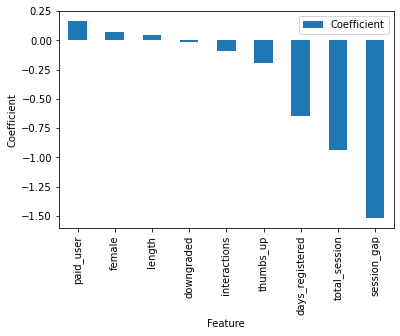

In [ ]:
FI = lsvcmodel.stages[-1].coefficients
model_FI = pd.DataFrame(list(zip(exp_features, FI)),  columns=['Feature', 'Coefficient']).sort_values('Coefficient', ascending=False)
        
model_FI.plot.bar(x='Feature', y='Coefficient')
plt.ylabel('Coefficient')

# GBT Classifier

In [ ]:
gbt = GBTClassifier()

In [ ]:
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [1, 2, 3])
             .addGrid(gbt.maxIter, [3, 5, 10])
             .build())

In [ ]:
gbtmodel, gbtresults, train_res = fit_model(gbt, train, test, paramGrid = paramGrid, train_score = True)

In [ ]:
print("TRAIN results:")
val_evaluation(train_res)
print("TEST results:")
val_evaluation(gbtresults)

TRAIN results:
Precision: 0.92
Recall: 0.6571428571428571
F1 positive class: 0.7666666666666667
F1 macro: 0.8575980392156863
AUC-PR: 0.7984302925989674 

TEST results:
Precision: 0.8
Recall: 0.36363636363636365
F1 positive class: 0.5000000000000001
F1 macro: 0.6944444444444444
AUC-PR: 0.625 



In [ ]:
best_param = list(gbtmodel.getEstimatorParamMaps()[np.argmax(gbtmodel.avgMetrics)].values())
print('Best GBT parameters are:', best_param[0], best_param[1])

Best GBT parameters are: 3 10


## Feature importances

Text(0, 0.5, 'FeatureImportances')

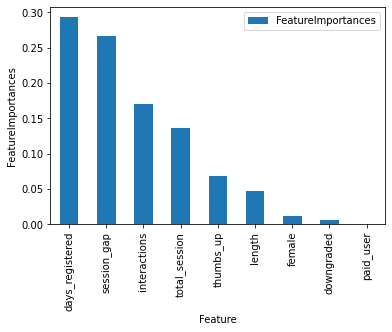

In [ ]:
exp_features = ['female','days_registered','paid_user',\
                                       'downgraded','total_session','interactions',\
                                      'thumbs_up','length','session_gap']
FI = gbtmodel.stages[-1].featureImportances
model_FI = pd.DataFrame(list(zip(exp_features, FI)), columns=['Feature', 'FeatureImportances']).sort_values('FeatureImportances', ascending=False)

model_FI.plot.bar(x='Feature', y='FeatureImportances')
plt.ylabel('FeatureImportances')

# Summary of results (F1 score)
- Logistic Regression: 0.71 
- Random Forest: 0.50
- SVM: 0.42
- GBT: 0.50

# Handling imbalanced class ratio to improve the results
- Handling imbalanced datasets is a common challenge in machine learning. When dealing with significantly unbalanced dataset in the target label, it becomes harder for most machine learning algorithms to efficiently learn all classes. The training process might be indeed biased towards a certain class if the dataset distribution is poorly balanced.

- In this specific case, only about 23.11% of the data are labelled as churn (label=1).

-  There are several ways to address this issue with PySpark and MLlib. We will focus on the following two approaches:
    - Resempling
    - Cost-based function (Weighting)

# Resampling

- While the obvious and most desirable solution would be to collect more real data, oversampling and undersampling are techniques that may still come in handy in these situations.
For both techniques there is a naïve approach that is the random oversampling (undersampling) where training data is incremented (decremented) with multiple copies of the samples, until the same proportion is obtained on the minority (majority) classes. A more sophisticated  approach is SMOTE oversampling which works by utilizing a k-nearest neighbour algorithm to create synthetic data from the minority class.

- So now let's test these three approaches to see if they bring some improvements. 

Always split into test and train sets BEFORE trying oversampling techniques! Oversampling before splitting the data can allow the exact same observations to be present in both the test and train sets. This can allow our model to simply memorize specific data points and cause overfitting and poor generalization to the test data.

## Downsampling

In [ ]:
from sklearn.utils import resample
import pandas as pd
# setting up testing and training sets
df_train, df_test = data.randomSplit([.75,.25],seed=42)

X_train = df_train.drop('label')
y_train = df_train.label

X_test = df_test.drop('label')
y_test = df_test.label
# concatenate our training data back together
X = df_train.toPandas()

In [ ]:
# separate minority and majority classes
not_churn = X[X.label==0]
churn = X[X.label==1]

In [ ]:


# downsample majority
not_churn_downsampled = resample(not_churn,
                                replace = False, # sample without replacement
                                n_samples = len(churn), # match minority n
                                random_state = 42) # reproducible results

# combine minority and downsampled majority
downsampled = pd.concat([not_churn_downsampled, churn])

# checking counts
downsampled.label.value_counts()

0    35
1    35
Name: label, dtype: int64

In [ ]:
train_downsampled = spark.createDataFrame(downsampled)

In [ ]:
lr_down = LogisticRegression(maxIter=10, elasticNetParam=1.0, regParam = 0.0001)
lr_down.setThreshold(0.65)
lr_down_model, lr_downsample_res = fit_model(lr_down, train_downsampled, df_test)
print("Test results:") 
val_evaluation(lr_downsample_res)

Test results:
Precision: 0.6666666666666666
Recall: 0.7272727272727273
F1 positive class: 0.6956521739130435
F1 macro: 0.7939799331103679
AUC-PR: 0.6098484848484849 



In [ ]:
rf_down = RandomForestClassifier(maxDepth=10, numTrees=20)
rf_down_model, rf_downsample_res = fit_model(rf_down, train_downsampled, df_test)
print("Test results:") 
val_evaluation(rf_downsample_res)

Test results:


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.5
Recall: 0.6363636363636364
F1 positive class: 0.56
F1 macro: 0.6926984126984127
AUC-PR: 0.45454545454545453 



In [ ]:
lsvc_down = LinearSVC(maxIter=10, regParam=0.0)
lsvc_down.setThreshold(0.5)
lsvc_down_model, lsvc_downsample_res = fit_model(lsvc_down, train_downsampled, df_test)
print("Test results:") 
val_evaluation(lsvc_downsample_res)

Test results:
Precision: 0.6666666666666666
Recall: 0.7272727272727273
F1 positive class: 0.6956521739130435
F1 macro: 0.7939799331103679
AUC-PR: 0.6098484848484849 



In [ ]:
gbt_down = GBTClassifier(maxIter=5, maxDepth=2)
gbt_down_model, gbt_downsample_res = fit_model(gbt_down, train_downsampled, df_test)
print("Test results:") 
val_evaluation(gbt_downsample_res)

Test results:
Precision: 0.36363636363636365
Recall: 0.7272727272727273
F1 positive class: 0.4848484848484849
F1 macro: 0.5878787878787879
AUC-PR: 0.34814049586776863 



## Upsampling

In [ ]:
# upsample minority
churn_upsampled = resample(churn,
                          replace=True, # sample with replacement
                          n_samples=len(not_churn), # match number in majority class
                          random_state=42) # reproducible results

# combine majority and upsampled minority
upsampled = pd.concat([not_churn, churn_upsampled])

# check new class counts
upsampled.label.value_counts()

0    131
1    131
Name: label, dtype: int64

In [ ]:
train_upsampled = spark.createDataFrame(upsampled)

In [ ]:
lr_up = LogisticRegression(maxIter=10, elasticNetParam=1.0, regParam = 0.0001)
lr_up.setThreshold(0.65)
lr_up_model, lr_upsample_res = fit_model(lr_up, train_upsampled, df_test)

In [ ]:
print("Test results:") 
val_evaluation(lr_upsample_res)

Test results:
Precision: 0.875
Recall: 0.6363636363636364
F1 positive class: 0.7368421052631579
F1 macro: 0.8321891685736079
AUC-PR: 0.7613636363636364 



In [ ]:
rf_up = RandomForestClassifier(maxDepth=10, numTrees=10)
rf_up_model, rf_upsample_res = fit_model(rf_up, train_upsampled, df_test)
print("Test results:")
val_evaluation(rf_upsample_res)

Test results:
Precision: 0.8333333333333334
Recall: 0.45454545454545453
F1 positive class: 0.5882352941176471
F1 macro: 0.7448218724109362
AUC-PR: 0.6742424242424243 



In [ ]:
lsvc_up = LinearSVC(maxIter=10, regParam=0.0)
lsvc_up.setThreshold(0.1)
lsvc_up_model, lsvc_upsample_res = fit_model(lsvc_up, train_upsampled, df_test)
print("Test results:")
val_evaluation(lsvc_upsample_res)

Test results:
Precision: 0.7777777777777778
Recall: 0.6363636363636364
F1 positive class: 0.7000000000000001
F1 macro: 0.8058823529411765
AUC-PR: 0.6818181818181819 



In [ ]:
gbt_up = GBTClassifier(maxIter=20, maxDepth=10)
gbt_up_model, gbt_upsample_res = fit_model(gbt_up, train_upsampled, df_test)
print("Test results:")
val_evaluation(gbt_upsample_res)

Test results:
Precision: 0.75
Recall: 0.5454545454545454
F1 positive class: 0.631578947368421
F1 macro: 0.7650648360030512
AUC-PR: 0.6363636363636364 



# SMOTE oversampling
Random oversampling simply duplicates existing minority class samples to increase their count, whereas SMOTE synthesizes new samples of the minority class based on the existing samples. In SMOTE, the algorithm selects a minority class sample and finds its k nearest neighbors in the feature space. It then generates synthetic samples by interpolating between the selected sample and one of its k nearest neighbors.

The advantage of SMOTE over random oversampling is that it generates synthetic samples that are similar to the existing minority class samples, which helps to preserve the underlying structure of the minority class. This can improve the performance of machine learning algorithms compared to random oversampling, which can lead to overfitting if the minority class is simply duplicated multiple times.

In [ ]:
# Split train/test data
df_train, df_test = data.randomSplit([0.75, 0.25], seed=42)
df_train = df_train.drop(df_train.NumFeatures)
df_test = df_test.drop(df_test.NumFeatures)

In [ ]:
df_smote = df_train.toPandas()
df_smote = df_smote.dropna()
df_test_sm = df_test.toPandas()
X_train = df_smote.drop(columns=['label'])
y_train = df_smote.label

X_test = df_test_sm.drop(columns=['label'])
y_test = df_test_sm.label
# concatenate our training data back together
#X = df_smote.toPandas()

In [ ]:
X_train = X_train.drop(columns=['date_created'])
X_train = X_train.dropna()

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts()

0    131
1    131
Name: label, dtype: int64

In [ ]:
X = pd.concat([X_train, y_train], axis = 1)

In [ ]:
out = spark.createDataFrame(X)

In [ ]:
data_train = assembler.transform(out)
# Use 'canceled' as model prediction label
data_train = data_train.withColumnRenamed('canceled','label')

In [ ]:
data_test = assembler.transform(df_test)
# Use 'canceled' as model prediction label
data_test = data_test.withColumnRenamed('canceled','label')

In [ ]:
lr_sm = LogisticRegression(maxIter=10, elasticNetParam=1.0, regParam = 0.0001)
lr_sm.setThreshold(0.65)
lr_sm_model, lr_sm_res = fit_model(lr_sm, data_train, data_test)

In [ ]:
print("Test results:") 
val_evaluation(lr_sm_res)

Test results:


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.8
Recall: 0.7272727272727273
F1 positive class: 0.761904761904762
F1 macro: 0.8436389481165602
AUC-PR: 0.7250000000000001 



In [ ]:
rf_sm = RandomForestClassifier(maxDepth=10, numTrees=20)
rf_sm_model, rf_sm_res = fit_model(rf_sm, data_train, data_test)
print("Test results:") 
val_evaluation(rf_sm_res)

Test results:
Precision: 1.0
Recall: 0.45454545454545453
F1 positive class: 0.625
F1 macro: 0.7708333333333333
AUC-PR: 0.7954545454545454 



In [ ]:
lsvc_sm = LinearSVC(maxIter=10, regParam=0.0)
lsvc_sm.setThreshold(0.2)
lsvc_sm_model, lsvc_sm_res = fit_model(lsvc_sm, data_train, data_test)
print("Test results:") 
val_evaluation(lsvc_sm_res)

Test results:
Precision: 0.7272727272727273
Recall: 0.7272727272727273
F1 positive class: 0.7272727272727273
F1 macro: 0.8181818181818181
AUC-PR: 0.6621900826446281 



In [ ]:
gbt_sm = GBTClassifier(maxIter=5, maxDepth=2)
gbt_sm_model, gbt_sm_res = fit_model(gbt_sm, data_train, data_test)
print("Test results:") 
val_evaluation(gbt_sm_res)

Test results:
Precision: 0.75
Recall: 0.5454545454545454
F1 positive class: 0.631578947368421
F1 macro: 0.7650648360030512
AUC-PR: 0.6363636363636364 



# Summary of results

| MODEL               | Downsampling  | Upsampling | SMOTE | 
|:-------------------:|:----:|:---------:|:----------:|
| Logistic Regression | 0.70 | 0.74      | 0.76       |
| Random Forest | 0.56 | 0.59      | 0.62       | 
| SVM | 0.73 | 0.70      | 0.73      |
| GBT Classfier | 0.48 | 0.63      | 0.63      |

From the results it is clearly possible to understand that Logistic Regression model is the best classifier for the current task. It managed to improve its F1-score up to 76% with SMOTE. 

# Reweight dataset

In PySpark, you can reweight the datasets for imbalanced binary classification by adjusting the class weights in the loss function used in the machine learning algorithm. This will make the model pay more attention to the minority class samples and help to balance the class distribution.
The **setClassWeight** method is used to set the class weights in each model.

In [ ]:
# Try weighted col since the cancelled outcome is unbalanced
balancingRatio = data.filter(col('label') == 1).count() / data.count()
calculateWeights = udf(lambda x: 1 * balancingRatio if x == 0 else (1 * (1.0 - balancingRatio)), DoubleType())

weightedDataset = data.withColumn("classWeightCol", calculateWeights('label'))

In [ ]:
weightedDataset.groupby('classWeightCol').count().show()

+-------------------+-----+
|     classWeightCol|count|
+-------------------+-----+
|0.21904761904761905|  164|
|  0.780952380952381|   46|
+-------------------+-----+



In [ ]:
train_weight, test_weight = weightedDataset.randomSplit([0.75, 0.25], seed=42)

In [ ]:
lr_weight = LogisticRegression(maxIter=10, elasticNetParam=1.0, regParam = 0.0001)
lr_weight.setWeightCol('classWeightCol')
lr_weight.setThreshold(0.65)
lrweightedmodel, lrweightedresults = fit_model(lr_weight, train_weight, test_weight)

In [ ]:
print("Test results:")
val_evaluation(lrweightedresults)

Test results:


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.8888888888888888
Recall: 0.7272727272727273
F1 positive class: 0.7999999999999999
F1 macro: 0.8705882352941177
AUC-PR: 0.8017676767676767 



In [ ]:
rf_weight = RandomForestClassifier(maxDepth=10, numTrees=20)
rf_weight.setWeightCol('classWeightCol')
rfweightedmodel, rfweightedresults = fit_model(rf_weight, train_weight, test_weight)
print("Test results:")
val_evaluation(rfweightedresults)

Test results:
Precision: 1.0
Recall: 0.36363636363636365
F1 positive class: 0.5333333333333333
F1 macro: 0.7187214611872146
AUC-PR: 0.7613636363636364 



In [ ]:
lsvc_weight = LinearSVC(maxIter=10, regParam=0.0)
lsvc_weight.setWeightCol('classWeightCol')
lsvc_weight.setThreshold(0.5)
lsvcweightedmodel, lsvcweightedresults, train_res = fit_model(lsvc_weight, train_weight, test_weight, train_score = True)
print("train results:")
val_evaluation(train_res)
print("Test results:")
val_evaluation(lsvcweightedresults)

train results:


/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Precision: 0.71875
Recall: 0.6571428571428571
F1 positive class: 0.6865671641791045
F1 macro: 0.8036609405801183
AUC-PR: 0.6316802925989673 

Test results:
Precision: 0.875
Recall: 0.6363636363636364
F1 positive class: 0.7368421052631579
F1 macro: 0.8321891685736079
AUC-PR: 0.7613636363636364 



In [ ]:
lsvc_weight = LinearSVC(maxIter=10, regParam=0.0)
lsvc_weight.setWeightCol('classWeightCol')
lsvc_weight.setThreshold(0.5)
lsvcweightedmodel, lsvcweightedresults = fit_model(lsvc_weight, train_weight, test_weight)
print("Test results:")
val_evaluation(lsvcweightedresults)

Test results:
Precision: 0.875
Recall: 0.6363636363636364
F1 positive class: 0.7368421052631579
F1 macro: 0.8321891685736079
AUC-PR: 0.7613636363636364 



In [ ]:
gbt_weight = GBTClassifier(maxIter=5, maxDepth=2)
gbt_weight.setWeightCol('classWeightCol')
gbtweightedmodel, gbtweightedresults = fit_model(gbt_weight, train_weight, test_weight)
print("Test results:")
val_evaluation(gbtweightedresults)

Test results:
Precision: 0.8333333333333334
Recall: 0.45454545454545453
F1 positive class: 0.5882352941176471
F1 macro: 0.7448218724109362
AUC-PR: 0.6742424242424243 



# Summary of results Weighting
- Logistic Regression: 0.80
- Random Forest: 0.53
- SVM: 0.74
- GBT: 0.59

**Logistic Regression further improve the previous score reached with SMOTE!** In some cases, reweighting the dataset may provide better results than resampling techniques because it does not change the distribution of the samples in the original dataset, and it allows the model to see the true distribution of the classes, as it happens in this case.
Weighting seems to be the best strategy for SVM as well. On the other hand, resampling techinques turned out to be the best choice for RF and GBT.

# Overall Results (f1-score)
| MODEL               | Baseline | Downsampling  | Upsampling | SMOTE | Weighting|
|:-------------------:|:----:|:----:|:---------:|:----------:|:----------:|
| Logistic Regression | 0.71| 0.70 | 0.74      | 0.76       | 0.80|
| Random Forest | 0.50|0.56 | 0.59      | 0.63       | 0.53|
| SVM | 0.42|0.69 | 0.70      | 0.73      | 0.74|
| GBT Classfier | 0.50|0.48 | 0.63      | 0.63      | 0.59|
